## Triton day1:

Triton is a framework from OpenAI designed to make it easier to write efficient GPU kernels. Unlike CUDA, which requires writing C++ code, Triton lets you write GPU code in a Python-like language while still achieving performance close to hand-optimized CUDA.

In [2]:
#lets write a simple 1d array addition on GPU
import triton
import triton.language as tl
import torch

In [3]:
@triton.jit
def add_kernel(x,y,z, n_ele, BLOCK_SIZE: tl.constexpr): #1st vector: x, 2nd vector: y, z: x+y output vec, n_ele: no of ele in array, BLOCK_SIZE number of element each block should process
  #first pid
  pid = tl.program_id(0) #row wise addition
  block_start = pid*BLOCK_SIZE #starting block
  offsets = block_start + tl.arange(0,BLOCK_SIZE) #list of pointers
  masks = offsets < n_ele #prevents out of bounds

  #load
  X = tl.load(x+offsets,mask=masks)
  Y = tl.load(y+offsets,mask=masks)

  #store
  tl.store(z+offsets,X+Y,mask=masks)


In [4]:
#launch grid
def add(x: torch.Tensor,y: torch.Tensor):
  output = torch.empty_like(x)
  n_elements = output.numel()

  grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )

  add_kernel[grid](x,y,output,n_elements,BLOCK_SIZE=1024)
  return output


In [5]:
torch.manual_seed(0)
size = 98432
x = torch.rand(size, device='cuda')
y = torch.rand(size, device='cuda')
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

tensor([1.3713, 1.3076, 0.4940,  ..., 0.4024, 1.7918, 1.0686], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 0.4024, 1.7918, 1.0686], device='cuda:0')
The maximum difference between torch and triton is 0.0


In [10]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device='cuda', dtype=torch.float32)
    y = torch.rand(size, device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

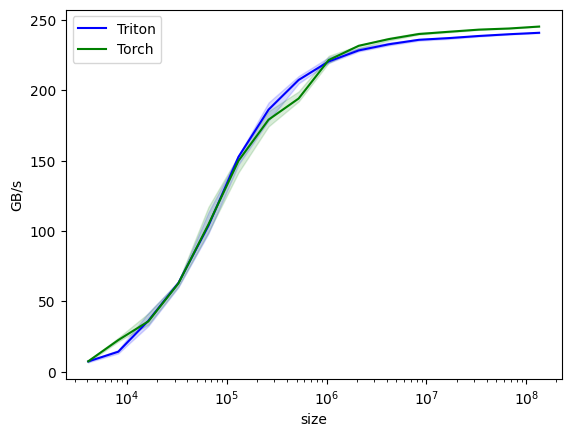

vector-add-performance:
           size      Triton       Torch
0        4096.0    7.245283    7.349282
1        8192.0   14.156682   22.423358
2       16384.0   36.141177   35.720930
3       32768.0   63.015384   62.693880
4       65536.0  103.696202  104.578724
5      131072.0  152.645959  149.853661
6      262144.0  186.181817  179.060113
7      524288.0  207.283078  194.084891
8     1048576.0  220.412561  221.405403
9     2097152.0  228.282153  231.575971
10    4194304.0  232.620583  236.307695
11    8388608.0  235.811693  239.921289
12   16777216.0  237.028815  241.533161
13   33554432.0  238.534090  243.044742
14   67108864.0  239.764709  243.845439
15  134217728.0  240.798819  245.218787


In [11]:
benchmark.run(print_data=True, show_plots=True)

### Key Concepts in Writing a Kernel

✅ Use `@triton.jit` to mark a function as a Triton kernel.

✅ Use `tl.program_id(dim)` to determine the work assignment.

✅ Use `tl.arange(start, end)` to compute memory offsets.

✅ Use `tl.load()` and `tl.store()` for memory access.

✅ Use `masks (mask=mask)` to avoid invalid memory access.

Lets look a little bit more deeper into some of the things in the code:

`tl.program_id(axis)` : Similar to the concept of threads in CUDA, the `program_id(axis)` line gives the unique ID of the current program instance.

The axis argument (0, 1, etc.) determines which dimension of the grid the ID corresponds to.

Since we were working with a 1D row vector, the only axis available was 0, so `program_id(0)` made sense.

**Offsets**

Offsets are used to compute memory addresses based on the program ID (`tl.program_id()`) and the block size. Let's look at an example based on our vector addition:



```python
pid = tl.program_id(0)  # Unique program ID
start = pid * BLOCK_SIZE  # Start index for this block
offsets = start + tl.arange(0, BLOCK_SIZE)  # Compute element indices

```

Let's say: N= 1024 and the BLOCK_SIZE=256:

| pid | start = pid * BLOCK_SIZE | offsets (range)         |
|-----|--------------------------|-------------------------|
| 0   | 0                        | [0, 1, ..., 255]       |
| 1   | 256                      | [256, 257, ..., 511]   |
| 2   | 512                      | [512, 513, ..., 767]   |
| 3   | 768                      | [768, 769, ..., 1023]                      |


Each program instance (block) processes a separate chunk of 256 elements.

**Triton `grid`**

`grid` enables us to launch the triton kernel. Let's breakdown the syntax:

```python
grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )

```
- This lambda function returns a tuple containing the number of blocks in the first dimension.
- `meta['BLOCK_SIZE']` refers to the block size used in the kernel (passed as a compile-time constant).
- `triton.cdiv(a, b)` is ceil division, which ensures we launch enough blocks to cover all elements.

With the same block size and elements we have:

`grid = (triton.cdiv(1024, 256), )  # Equivalent to (ceil(1024 / 256), )` which gives us `4`. Meaning 4 blocks will be launched.




